### Detect the circle point using NN

In [1]:
import torch 
import pandas as pd
from PIL import Image
from torch import nn 
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
df = pd.read_csv("labels.csv", header=None)
labels, file_name = df[[1, 2]].to_numpy(), df[3].to_list()

In [3]:
class ImageDataset(Dataset) :
    def __init__(self, image_list, labels) :
        self.image_list = image_list
        self.labels = labels
    
    def __len__(self) :
        return len(self.image_list)

    def __getitem__(self, idx) :
        if torch.is_tensor(idx) :
            idx = idx.tolist()
        
        image_name = self.image_list[idx]
        image = transforms.ToTensor()(Image.open(image_name).convert("L"))
        label = self.labels[idx]
        return image, label

In [4]:
dataset = ImageDataset(file_name, labels)
dataloader = DataLoader(dataset, batch_size=len(file_name), shuffle=True)
dataloader

In [5]:
for image, label in dataloader :
    print(image.shape)
    print(label.shape)

torch.Size([30, 1, 120, 120])
torch.Size([30, 2])


In [6]:
def show_image(image, label) :
    x, y = label
    plt.title(f"point at x: {x}, y: {y}")
    plt.scatter(x, y, s=14, c="b")
    plt.imshow(image.permute(1, 2, 0), cmap="gray")

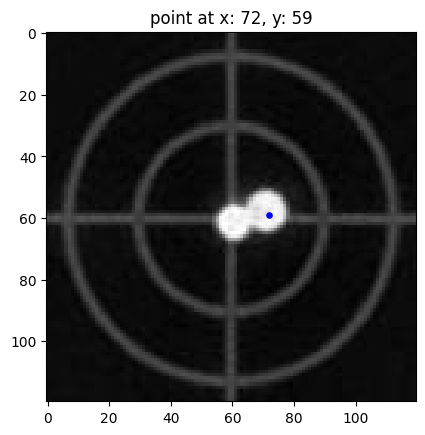

In [7]:
idx = 12
show_image(image[idx], label[idx])

In [8]:
train_size = int(0.8*len(file_name))
train_images, train_labels = image[:train_size], label[:train_size]
val_images, val_labels = image[train_size:], label[train_size:]
train_images.shape, train_labels.shape, val_images.shape, val_labels.shape

(torch.Size([24, 1, 120, 120]),
 torch.Size([24, 2]),
 torch.Size([6, 1, 120, 120]),
 torch.Size([6, 2]))

In [39]:
class point_detect(nn.Module) :
    def __init__(self, input_size) :
        super(point_detect, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, 2, bias=False)
        self.fc2 = nn.Linear(2, 2, bias=False)
        # self.fc3 = nn.Linear(4, 2, bias=False)

    def forward(self, x) :
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.fc3(x)
        return x

In [59]:
IMAGE_SIZE = 120
EPOCHS = 10000
LR = 0.05
model = point_detect(IMAGE_SIZE*IMAGE_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [91]:
best_loss = torch.inf
best_epoch = None
train_losses = []
val_lossses = []
for epoch in range(EPOCHS) :
    break
    if epoch > EPOCHS*0.2 : optimizer.param_groups[0]["lr"] = 0.005
    model.train()
    outs = model(train_images)
    t_loss = criterion(outs, train_labels.float())

    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()

    train_losses.append(t_loss.item())
    print(f"\nepoch: {epoch+1}")
    print(f"train_loss: {t_loss.item():.4f}")
    
    with torch.inference_mode() :
        model.eval()
        outs = model(val_images)
        v_loss = criterion(outs, val_labels.float())
        val_lossses.append(v_loss.item())
        print(f"val_loss: {v_loss.item():.4f}")

        if v_loss < best_loss :
            best_epoch = epoch + 1
            best_loss = v_loss
            torch.save(model.state_dict(), "point_detect_weights.pth")
            print("[INFO] saved model weights")

print(f"\n[INFO] best_epoch: {best_epoch}")


[INFO] best_epoch: None


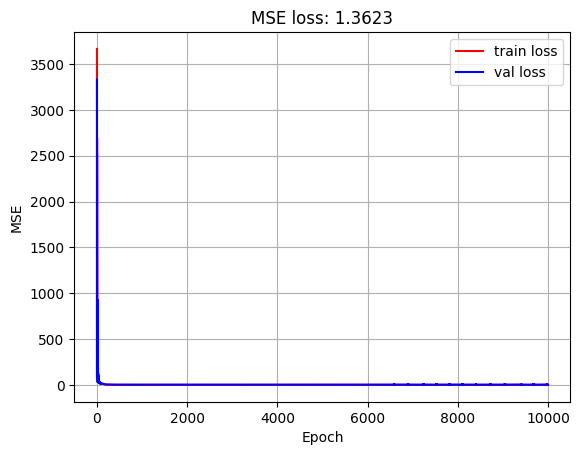

In [61]:
epochs = [i for i in range(EPOCHS)]
plt.title(f"MSE loss: {best_loss:.4f}")
plt.plot(epochs, train_losses, color="red", label="train loss")
plt.plot(epochs, val_lossses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()

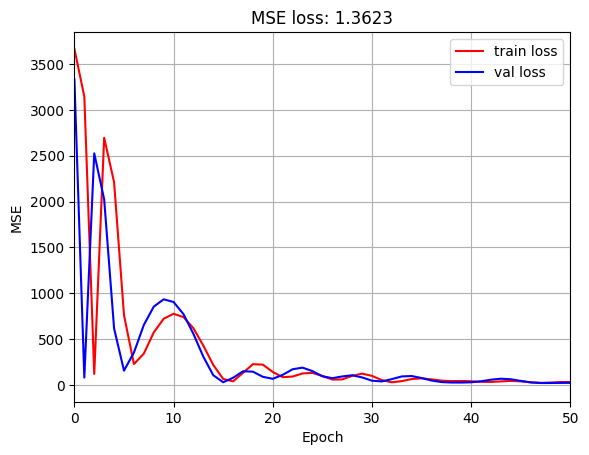

In [83]:
plt.title(f"MSE loss: {best_loss:.4f}")
plt.plot(epochs, train_losses, color="red", label="train loss")
plt.plot(epochs, val_lossses, color="blue", label="val loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.xlim([0, 50])
plt.legend()

In [62]:
point_detector = point_detect(IMAGE_SIZE*IMAGE_SIZE)
point_detector.load_state_dict(torch.load("point_detect_weights.pth"))

<All keys matched successfully>

MSE loss: 1.6918


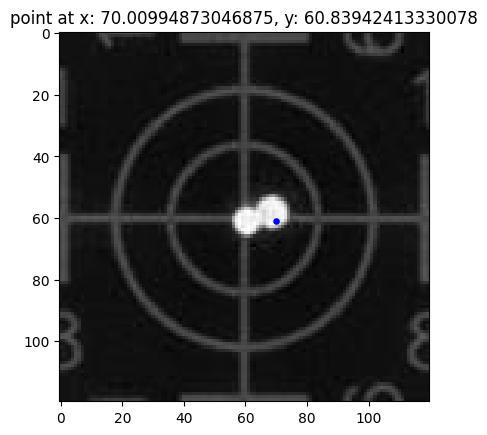

In [231]:
with torch.inference_mode() :
        point_detector.eval()
        idx = 3
        outs = point_detector(val_images[idx])
        v_loss = criterion(outs, val_labels[idx].float())
        show_image(val_images[idx], outs[0])
        print(f"MSE loss: {v_loss.item():.4f}")

In [95]:
fc1 = point_detector.fc1.weight.detach().numpy()
fc1

array([[-0.00340883, -0.00236649, -0.016898  , ..., -0.02733235,
        -0.00628905, -0.01286588],
       [-0.12879324, -0.11946889, -0.13004494, ..., -0.12846728,
        -0.13644682, -0.12399084]], dtype=float32)

In [96]:
fc2 = point_detector.fc2.weight.detach().numpy()
fc2

array([[-0.27190685, -0.18606894],
       [ 0.12890649, -0.20336477]], dtype=float32)

In [113]:
import numpy as np

In [125]:
val_images[2].view(-1).shape

torch.Size([14400])

In [123]:
x = np.dot(fc1, val_images[2].view(-1))
x = np.dot(fc2, x)
x

array([51.691864, 59.563107], dtype=float32)

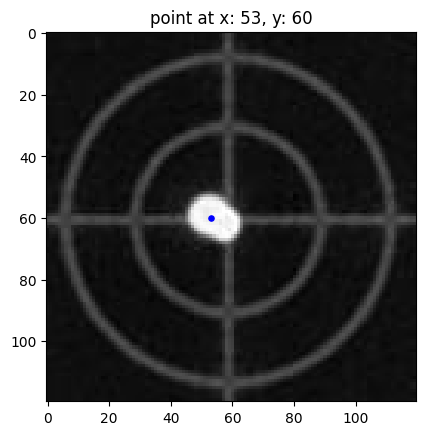

In [98]:
show_image(val_images[2], val_labels[2])

In [180]:
class SmallPointNet(nn.Module):
    def __init__(self):
        super(SmallPointNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)  
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3)  
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.fc1 = nn.Linear(32 * 13 * 13, 128)  
        self.fc2 = nn.Linear(128, 2)  

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) 
        x = self.pool(torch.relu(self.conv2(x)))  
        x = self.pool(torch.relu(self.conv3(x)))  
        x = x.view(-1, 5408)  
        x = torch.relu(self.fc1(x)) 
        x = self.fc2(x)  
        return x

In [190]:
modelcnn = SmallPointNet()

In [209]:
EPOCHS = 500
LR = 0.0007
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelcnn.parameters(), lr=LR)

In [213]:
best_loss = torch.inf
best_epoch = None
train_losses = []
val_lossses = []
for epoch in range(EPOCHS) :
    break
    if epoch > EPOCHS*0.2 : optimizer.param_groups[0]["lr"] = LR*0.3
    modelcnn.train()
    outs = modelcnn(train_images)
    t_loss = criterion(outs, train_labels.float())

    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()

    train_losses.append(t_loss.item())
    print(f"\nepoch: {epoch+1}")
    print(f"train_loss: {t_loss.item():.4f}")
    
    with torch.inference_mode() :
        modelcnn.eval()
        outs = modelcnn(val_images)
        v_loss = criterion(outs, val_labels.float())
        val_lossses.append(v_loss.item())
        print(f"val_loss: {v_loss.item():.4f}")

        if v_loss < best_loss :
            best_epoch = epoch + 1
            best_loss = v_loss
            torch.save(modelcnn.state_dict(), "point_detect_cnn_weights.pth")
            print("[INFO] saved model weights")

print(f"\n[INFO] best_epoch: {best_epoch}")


[INFO] best_epoch: None


MSE loss: 1.1967
Ground Truth vs Prediction


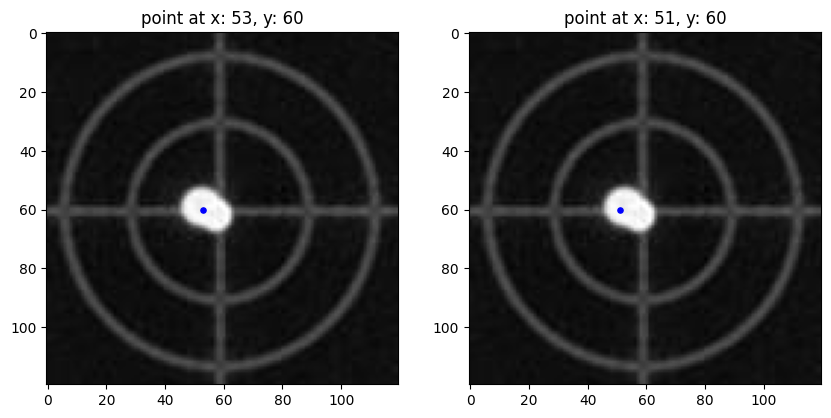

In [286]:
point_net = SmallPointNet()
point_net.load_state_dict(torch.load("point_detect_cnn_weights.pth"))

with torch.inference_mode() :
        point_net.eval()
        idx = 2
        outs = point_net(val_images[idx])
        v_loss = criterion(outs, val_labels[idx].float())
        x = round(float(outs[0][0].detach()))
        y = round(float(outs[0][1].detach()))

        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        show_image(val_images[idx], val_labels[idx])
        plt.subplot(1, 2, 2)
        show_image(val_images[idx], [x, y])

        print(f"MSE loss: {v_loss.item():.4f}")
        print("Ground Truth vs Prediction")